In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import json
import pandas as pd
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

First, we create 100 symptoms with gpt4o. This mock data is used to create Chat Completions for training dataset to fine-tune smaller model. 

In [4]:
with open('user_symptoms.json', 'r') as file:
        user_messages = json.load(file)
        for symptom in user_messages:
            print(symptom)

I have had a strange buzzing in my ears for the last 19 days
I have had my left arm feeling colder than the right for the last 18 days
I have had an odd taste in my mouth every morning for the last 21 days
I have had intermittent double vision when reading for the last 4 days
I have had a burning sensation after eating spicy food for the last 6 days
I have had a clicking sound in my jaw for the last 13 days
I have had sharp pain in my pinky toe for the last 9 days
I have had random nose twitching for the last 13 days
I have had sudden urge to nap at odd hours for the last 9 days
I have had tingling on the top of my head for the last 10 days
I have had numbness in my upper lip for the last 5 days
I have had random muscle spasms in my thighs for the last 19 days
I have had difficulty focusing on conversations for the last 10 days
I have had heaviness in my eyelids during the day for the last 7 days
I have had feeling like my heart skips a beat for the last 20 days
I have had tightness in

This function defines roles for a completion with more precise approach, setting low temperature and 90% threshold, since it is healthcare. Metadata is used to filter out completions used for distillation.

In [5]:
def get_openai_response(model_name, symptom):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {
                "role": "developer",
                "content": """
                You are an medicine expert in identifying the correct doctor according to the patient symptoms. Respond with a list of doctors that are relevant to the provided symptom. 
Example of user symptom could be 'I have diarrhea for 3 days'. Your answer should look like this 'Gastroenterologist'.
                """
            },
            {"role": "user", "content": symptom},
        ],
        temperature=0.15, #more precise answer
        top_p=0.9, 
        store=True,
        metadata={
            "role": "distillation",
            "distillation_version": "1"
        }
    )
    print(f"Response from {model_name}:")
    print(f"Symptom: {symptom}")
    print(response.choices[0].message.content)
    print("=" * 50)

In [8]:
def complete_all_symptoms(model_name):
    print(f"Generating with model: {model_name}:")
    with open('user_symptoms.json', 'r') as file:
        user_messages = json.load(file)
        for symptom in user_messages:
            get_openai_response(model_name, symptom)

The teacher model is used - large OpenAI gpt4o model.

In [9]:
complete_all_symptoms("gpt-4o")

Generating with model: gpt-4o:
Response from gpt-4o:
Symptom: I have had a strange buzzing in my ears for the last 19 days
Otolaryngologist (ENT Specialist)
Response from gpt-4o:
Symptom: I have had my left arm feeling colder than the right for the last 18 days
Vascular Specialist, Neurologist
Response from gpt-4o:
Symptom: I have had an odd taste in my mouth every morning for the last 21 days
Otolaryngologist (ENT Specialist)
Response from gpt-4o:
Symptom: I have had intermittent double vision when reading for the last 4 days
Ophthalmologist
Response from gpt-4o:
Symptom: I have had a burning sensation after eating spicy food for the last 6 days
Gastroenterologist
Response from gpt-4o:
Symptom: I have had a clicking sound in my jaw for the last 13 days
Oral and Maxillofacial Surgeon, Dentist, or an Otolaryngologist (ENT Specialist).
Response from gpt-4o:
Symptom: I have had sharp pain in my pinky toe for the last 9 days
Podiatrist
Response from gpt-4o:
Symptom: I have had random nose 

These responses are stored in OpenAI platform where we can distill and fine-tune smaller student base model gpt4o-mini.

In [10]:
complete_all_symptoms("ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs")

Generating with model: ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Response from ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Symptom: I have had a strange buzzing in my ears for the last 19 days
Otolaryngologist (ENT Specialist)
Response from ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Symptom: I have had my left arm feeling colder than the right for the last 18 days
Vascular Specialist, Neurologist, Rheumatologist
Response from ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Symptom: I have had an odd taste in my mouth every morning for the last 21 days
Otolaryngologist (ENT Specialist)
Response from ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Symptom: I have had intermittent double vision when reading for the last 4 days
Ophthalmologist
Response from ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Symptom: I have had a burning sensation after eating spicy food for the last 6 days
Gastroenterologist
Response from ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs:
Symptom: I have had a 

We evaluate the fine-tuned model using OpenAI Evals dashboard on the unseen symptoms with labeled appropriate doctor. Mock data is created using gpt4o without the memory of "training" symptoms. We assume that the doctor assigned by gpt4o is "ideal" answer.

In [12]:
df = pd.read_csv('symptom_doctor_mock_data.csv')
df.head()

,Symptom,Doctor
0,Chest pain,Cardiologist
1,Shortness of breath,Pulmonologist
2,Skin rash,Dermatologist
3,Frequent headaches,Neurologist
4,Joint pain,Rheumatologist


We use simple string check grader in order to compare the response generated by different models with actual, presumably "ideal" doctor. The response should contain the mock Doctor column.  

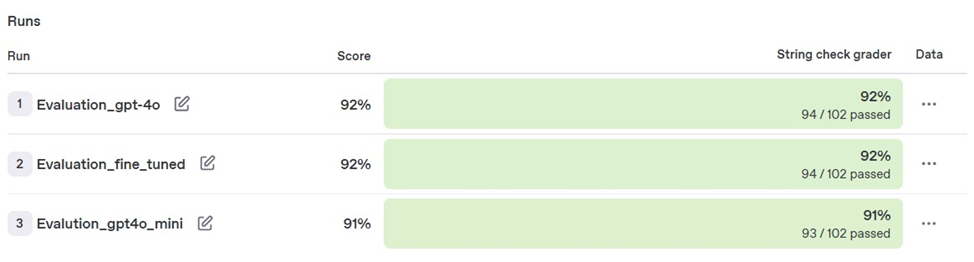

The fine-tuned smaller model is equally good as large gpt4o and slightly surpasses gpt4o-mini. That means it is more efficient (cost- and computationally-wise).

## Simple Chatbot ##

Distillation and Evals enable faster, real-time, accessible responses for patients with lower infrastructure costs and limited resources. Integrating these responses with appointment scheduling may ease customer service. Here is an example of simple chatbot that can be integrate to healthcare provider system. 

In [13]:
#!pip install gradio
import gradio as gr

In [23]:
model_id = "ft:gpt-4o-mini-2024-07-18:personal::BMV2QtXs"

def chat(message, history):
    messages = [{"role": "system", "content": """
                You are an medicine expert in identifying the correct doctor according to the patient symptoms. Respond with a list of doctors that are relevant to the provided symptom. 
Example of user symptom could be 'I have diarrhea for 3 days'. Your answer should look like this 'Gastroenterologist'.
                """}]
    messages += history
    messages.append({"role": "user", "content": message})
    
    response = client.chat.completions.create(
        model=model_id,
        messages=messages
    )
    reply = response.choices[0].message.content.strip()
    history.append({"role": "user", "content": message})
    history.append({"role": "assistant", "content": reply})
    return "", history

In [25]:
with gr.Blocks() as demo:
    gr.Markdown("### 🩺 Symptom-to-Doctor Chatbot (Fine-tuned Model)")
    chatbot = gr.Chatbot(type="messages")
    msg = gr.Textbox(placeholder="Describe your symptom and press Enter...")
    msg.submit(chat, [msg, chatbot], [msg, chatbot])

demo.launch()

* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In [ ]:
#Examples 
#I twisted my ankle while playing football
#I cannot sleep in the night 